In [ ]:
!pip install segmentation-models
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 279.9 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw
To: /content/Tumor.zip
100% 156M/156M [00:00<00:00, 167MB/s]


In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive('Tumor.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 8.5 MB/s eta 0:00:00
patool: Extracting Tumor.zip ...
patool: running /usr/bin/7z x -o./Unpack_fcfmq4tg -- Tumor.zip
patool: ... Tumor.zip extracted to `Tumor'.


'Tumor'

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

In [ ]:
SIZE = 128

train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/Tumor/Training/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
print(len(train_images))        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

pituitary
glioma
notumor
meningioma
5712


In [ ]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/Tumor/Testing/*"):
    fruit_label = directory_path.split("/")[-1]
    print(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
print(len(test_images))            
test_images = np.array(test_images)
test_labels = np.array(test_labels)

pituitary
glioma
notumor
meningioma
1311


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())
     

In [ ]:
class_no = 4
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(class_no, activation = 'softmax')(x)
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [ ]:
history = cnn_model.fit(x_train, y_train_one_hot, epochs=100, validation_data = (x_test, y_test_one_hot))

Epoch 1/100
179/179 [==============================] - 9s 52ms/step - loss: 0.0699 - accuracy: 0.9746 - val_loss: 0.6527 - val_accuracy: 0.8162
Epoch 2/100
179/179 [==============================] - 9s 50ms/step - loss: 0.0731 - accuracy: 0.9779 - val_loss: 0.3564 - val_accuracy: 0.8818
Epoch 3/100
179/179 [==============================] - 9s 51ms/step - loss: 0.0646 - accuracy: 0.9778 - val_loss: 0.2427 - val_accuracy: 0.9230
Epoch 4/100
179/179 [==============================] - 9s 52ms/step - loss: 0.0566 - accuracy: 0.9832 - val_loss: 0.2713 - val_accuracy: 0.9138
Epoch 5/100
179/179 [==============================] - 9s 52ms/step - loss: 0.0712 - accuracy: 0.9778 - val_loss: 0.6882 - val_accuracy: 0.7986
Epoch 6/100
179/179 [==============================] - 10s 56ms/step - loss: 0.0531 - accuracy: 0.9818 - val_loss: 0.2327 - val_accuracy: 0.9336
Epoch 7/100
179/179 [==============================] - 9s 52ms/step - loss: 0.0445 - accuracy: 0.9848 - val_loss: 0.2712 - val_accuracy

In [ ]:
cnn_model.save("cnn_model.h5")

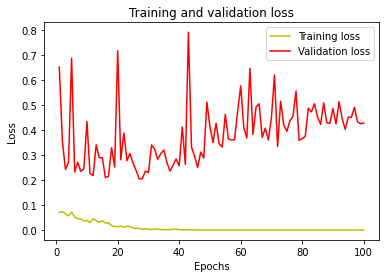

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

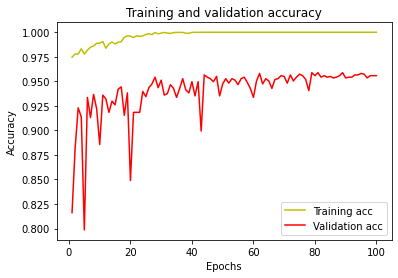

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

41/41 [==============================] - 1s 15ms/step


1/1 [==============================] - 0s 24ms/step
The prediction for this image is:  ['notumor']
The actual label for this image is:  notumor


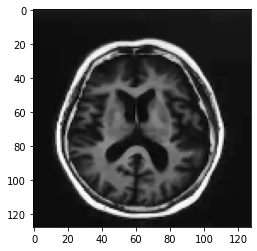

In [ ]:
n=600  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])
     

Accuracy =  0.9557589626239512
              precision    recall  f1-score   support

      glioma       0.96      0.91      0.93       300
  meningioma       0.90      0.92      0.91       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



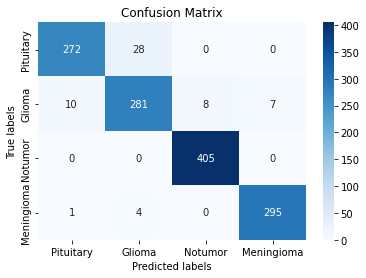

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt   
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_NN)) 
ax= plt.subplot()
cm = confusion_matrix(test_labels, prediction_NN)
#print(cm)
sns.heatmap(cm, annot=True,cmap="Blues",fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]); 
ax.yaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]);
d = {'Expected': test_labels, 'Predicted': prediction_NN}
results = pd.DataFrame(data=d)
print(classification_report(results['Expected'], results['Predicted']))

In [ ]:

X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

41/41 [==============================] - 1s 13ms/step


Accuracy =  0.9244851258581236
              precision    recall  f1-score   support

      glioma       0.95      0.80      0.87       300
  meningioma       0.83      0.89      0.86       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



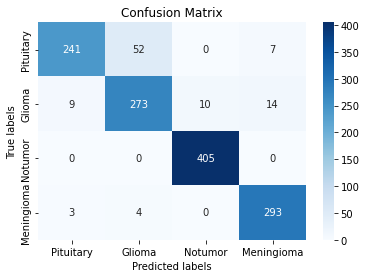

In [ ]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF)) 
ax= plt.subplot()
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True,cmap="Blues",fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]); 
ax.yaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]);
d = {'Expected': test_labels, 'Predicted': prediction_RF}
results = pd.DataFrame(data=d)
print(classification_report(results['Expected'], results['Predicted']))

1/1 [==============================] - 0s 23ms/step
The prediction for this image is:  ['pituitary']
The actual label for this image is:  pituitary


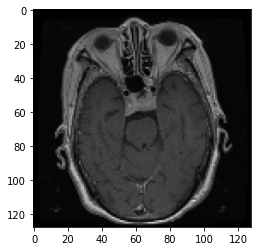

In [ ]:
n=250 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

In [ ]:
import shutil
shutil.copy("/content/yolov7_640_100.zip","/content/drive/MyDrive/Colab Notebooks/Results")